In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model, load_model  # Make sure load_model is imported
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build the CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Adjust for the number of classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train your model (ensure you have training data)
cnn_model = build_cnn_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Data Augmentation using ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

def load_images_from_dir(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize images to a fixed size
                images.append(img)
                labels.append(label)
    return images, labels

In [ ]:
!unzip -O UTF-8 /content/archive.zip

Archive:  /content/archive.zip
  inflating: Test cases/000001_03_01_088.png  
  inflating: Test cases/000017_02_01_016.png  
  inflating: Test cases/000019_01_01_021.png  
  inflating: Test cases/000019_02_01_025.png  
  inflating: Test cases/000019_03_01_025.png  
  inflating: Test cases/000020_01_01_066.png  
  inflating: Test cases/000020_02_01_062.png  
  inflating: Test cases/000020_03_01_134.png  
  inflating: Test cases/000020_03_01_166.png  
  inflating: Test cases/000020_03_01_212.png  
  inflating: Test cases/000020_04_01_116.png  
  inflating: Test cases/000020_04_01_143.png  
  inflating: Test cases/000020_04_01_159.png  
  inflating: Test cases/000021_01_01_016.png  
  inflating: Test cases/000021_02_01_068.png  
  inflating: Test cases/000021_03_01_012.png  
  inflating: Test cases/000021_03_01_017.png  
  inflating: Test cases/000021_04_01_090.png  
  inflating: Test cases/000027_01_01_113.png  
  inflating: Test cases/000027_02_01_105.png  
  inflating: Test cases/00002

# Directories for data

In [ ]:
benign_dir = r"/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = r"/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
normal_dir = r"/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases"

benign_images, benign_labels = load_images_from_dir(benign_dir, label=0)
malignant_images, malignant_labels = load_images_from_dir(malignant_dir, label=1)
normal_images, normal_labels = load_images_from_dir(normal_dir, label=2)

images = benign_images + malignant_images + normal_images
labels = benign_labels + malignant_labels + normal_labels

images = np.array(images).reshape(-1, 128, 128, 1) / 255.0
images = np.array(images)
labels = np.array(labels)

# Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Visualisation

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

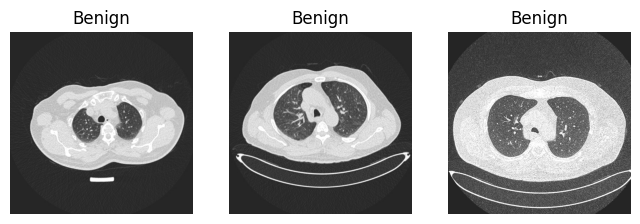

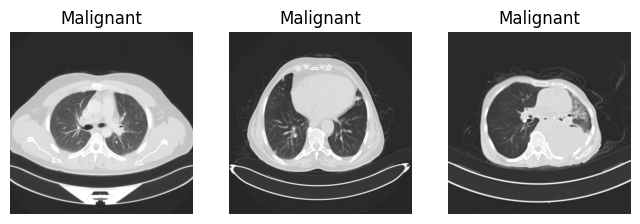

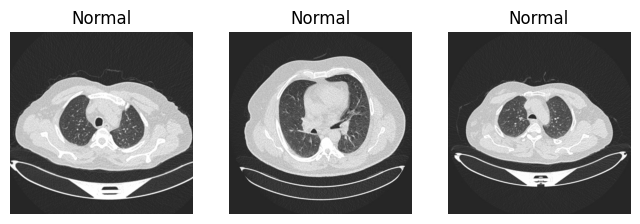

In [ ]:
# Define the categories and their corresponding image paths
categories = {
    "Benign": benign_dir,
    "Malignant": malignant_dir,
    "Normal": normal_dir
}

# Iterate over categories
for category, image_dir in categories.items():
    # Load images from the directory
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png'))]

    # Create subplots for each category
    fig, ax = plt.subplots(1, 3, figsize=(8, 8))
    ax = ax.ravel()

    # Randomly sample 3 images from each category
    for i, img_path in enumerate(np.random.choice(image_paths, size=3, replace=False)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(category)

    plt.show()

In [ ]:
# Create a DataFrame with the counts of each category
count_data = pd.DataFrame({
    "label": ["Benign", "Malignant", "Normal"],
    "count": [len(benign_images), len(malignant_images), len(normal_images)]
})

# Create histogram using Plotly Express
fig = px.histogram(data_frame=count_data, x="label", y="count", color="label")

# Show the histogram
fig.show()


# CNN Model for feature extraction


In [ ]:
from tensorflow import keras

def build_cnn_model():
  """
  Builds a convolutional neural network model for image classification.

  Returns:
      A compiled Keras model.
  """

  # Define the input shape
  input_shape = (128, 128, 1)  # Assuming grayscale images of size 128x128

  # Create the input layer explicitly
  inputs = keras.Input(shape=input_shape)

  # Build the Sequential model
  model = keras.Sequential([
      inputs,  # Add the input layer to the model
      keras.layers.Conv2D(32, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Conv2D(64, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Conv2D(128, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(3, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

cnn_model = build_cnn_model()

# Train CNN model


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

def build_cnn_model():
    input_shape = (128, 128, 1)
    inputs = keras.Input(shape=input_shape)

    # Define the CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example: Assuming you have loaded your data into X_train, X_test, y_train, y_test
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build and train the model
cnn_model = build_cnn_model()
history = cnn_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Create a feature extractor from the trained model
feature_extractor = models.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(index=-3).output)

# Extract features
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4328 - loss: 1.3124 - val_accuracy: 0.6136 - val_loss: 0.8863
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6210 - loss: 0.8804 - val_accuracy: 0.6193 - val_loss: 0.7655
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7051 - loss: 0.7023 - val_accuracy: 0.7045 - val_loss: 0.6839
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7919 - loss: 0.4983 - val_accuracy: 0.8295 - val_loss: 0.4765
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8442 - loss: 0.3790 - val_accuracy: 0.8125 - val_loss: 0.4813
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9131 - loss: 0.2514 - val_accuracy: 0.8920 - val_loss: 0.2930
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9520 - loss: 0.1420 - val_accuracy: 0.9091 - val_loss: 0.2187
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9871 - loss: 0.0776 - val_accuracy: 0.9432 - val_loss:

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def history_plot(history):
    epochs = len(history.history['accuracy'])
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["accuracy"], name="Training Accuracy"))
    fig1.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["val_accuracy"], name="Validation Accuracy"))
    fig1.update_layout(title="Training and Validation Accuracy", xaxis_title="Epoch", yaxis_title="Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["loss"], name="Training Loss"))
    fig2.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["val_loss"], name="Validation Loss"))
    fig2.update_layout(title="Training and Validation Loss", xaxis_title="Epoch", yaxis_title="Loss")
    fig2.show()

history_plot(history)


# Evaluate CNN model

In [ ]:
from tensorflow.keras.utils import to_categorical

y_test_encoded = to_categorical(y_test, num_classes=3)  # Assuming 3 classes
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_encoded)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9460 - loss: 0.1756


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.9460 - loss: 0.1756
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.79      0.88        29
     Class 1       0.96      0.99      0.98       109
     Class 2       0.92      0.95      0.93        82

    accuracy                           0.95       220
   macro avg       0.96      0.91      0.93       220
weighted avg       0.95      0.95      0.95       220

Test Loss: 0.1611604392528534
Test Accuracy: 0.949999988079071


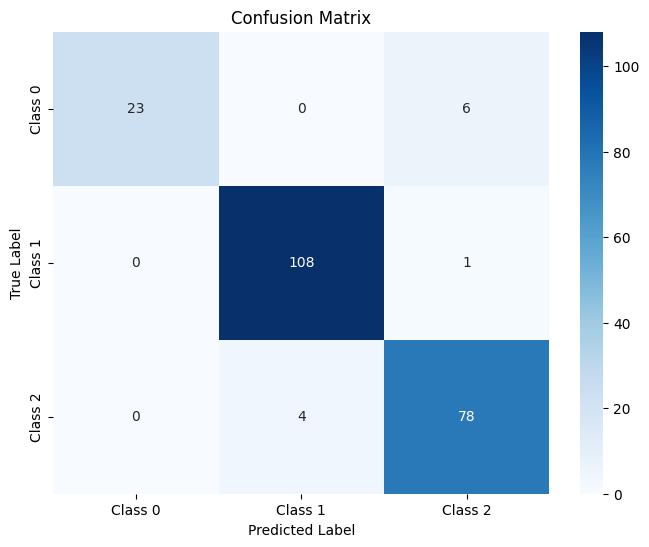

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have y_test as your true labels
num_classes = 3
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_encoded)

# Predict class probabilities
y_pred_prob = cnn_model.predict(X_test)

# Convert probabilities to class labels
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(num_classes)]))

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()






# Feature extraction from CNN model

In [ ]:

# Create the feature extractor using the trained CNN model
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)  # Access output of second-to-last layer

# Extract features
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 512ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step


In [ ]:
print(test_features.shape)


(220, 512)


# Random Forest Classifier

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Convert one-hot encoded labels to integer labels (if needed)
y_train_int = np.argmax(y_train_encoded, axis=1)
y_test_int = np.argmax(y_test_encoded, axis=1)

# Fit the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_features, y_train_int)

# Predict and calculate accuracy
y_pred_rf = rf_model.predict(test_features)
rf_acc = accuracy_score(y_test_int, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc}')

# Generate and print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test_int, y_pred_rf))


Random Forest Accuracy: 0.9545454545454546
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        29
           1       0.95      0.99      0.97       109
           2       0.95      0.93      0.94        82

    accuracy                           0.95       220
   macro avg       0.97      0.94      0.95       220
weighted avg       0.96      0.95      0.95       220




# SVM Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert one-hot encoded labels to integer labels (if needed)
y_train_int = np.argmax(y_train_encoded, axis=1)
y_test_int = np.argmax(y_test_encoded, axis=1)

# Train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, y_train_int)

# Predict on the test set
y_pred_svm = svm_model.predict(test_features)

# Calculate accuracy
svm_acc = accuracy_score(y_test_int, y_pred_svm)
print(f'SVM Accuracy: {svm_acc}')

# Generate and print classification report
print("Classification Report for SVM:")
print(classification_report(y_test_int, y_pred_svm))


SVM Accuracy: 0.990909090909091
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       1.00      1.00      1.00       109
           2       0.99      0.99      0.99        82

    accuracy                           0.99       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.99      0.99      0.99       220




# Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train_encoded, axis=1)
y_test_int = np.argmax(y_test_encoded, axis=1)

# Train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_features, y_train_int)

# Predict on the test set
y_pred_logreg = log_reg_model.predict(test_features)

# Calculate accuracy
logreg_acc = accuracy_score(y_test_int, y_pred_logreg)
print(f'Logistic Regression Accuracy: {logreg_acc}')

# Generate and print classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_int, y_pred_logreg))


Logistic Regression Accuracy: 0.9863636363636363
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.99      0.99      0.99       109
           2       0.98      0.99      0.98        82

    accuracy                           0.99       220
   macro avg       0.99      0.98      0.99       220
weighted avg       0.99      0.99      0.99       220



# DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train_encoded, axis=1)
y_test_int = np.argmax(y_test_encoded, axis=1)

# Train Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(train_features, y_train_int)

# Predict on the test set
y_pred_dt = dt_model.predict(test_features)

# Calculate accuracy
dt_acc = accuracy_score(y_test_int, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_acc}')

# Generate and print classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test_int, y_pred_dt))


Decision Tree Accuracy: 0.9545454545454546
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.98      0.99      0.99       109
           2       0.93      0.95      0.94        82

    accuracy                           0.95       220
   macro avg       0.94      0.92      0.93       220
weighted avg       0.95      0.95      0.95       220



# Compare model performances

In [ ]:
print("\nModel Performance Summary:")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"SVM Accuracy: {svm_acc}")
print(f"Logistic Regression Accuracy: {logreg_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")



Model Performance Summary:
Random Forest Accuracy: 0.9545454545454546
SVM Accuracy: 0.990909090909091
Logistic Regression Accuracy: 0.9863636363636363
Decision Tree Accuracy: 0.9545454545454546



# Confusion Matrix for all models

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Plot confusion matrix for each model

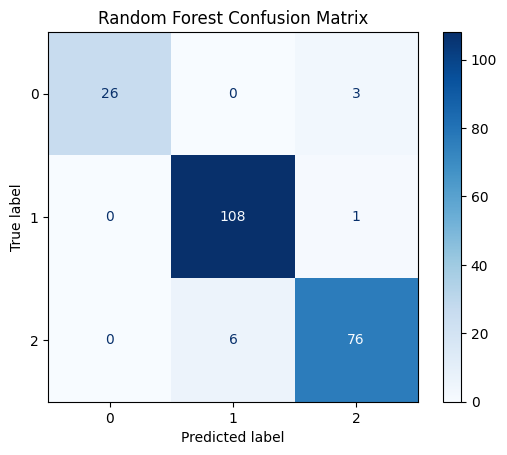

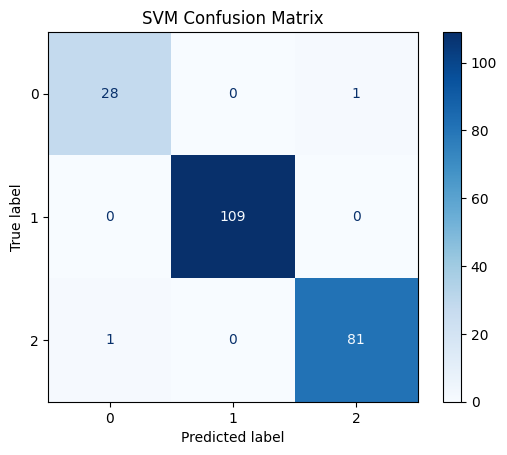

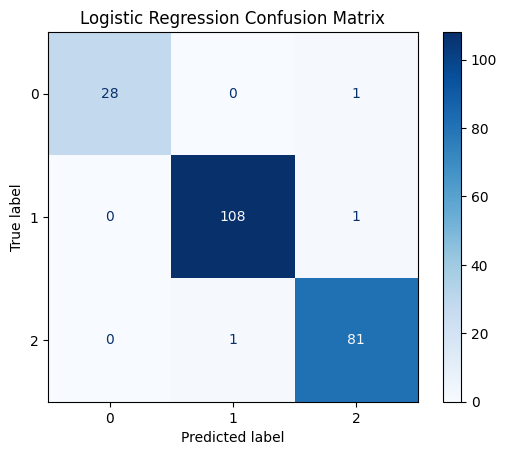

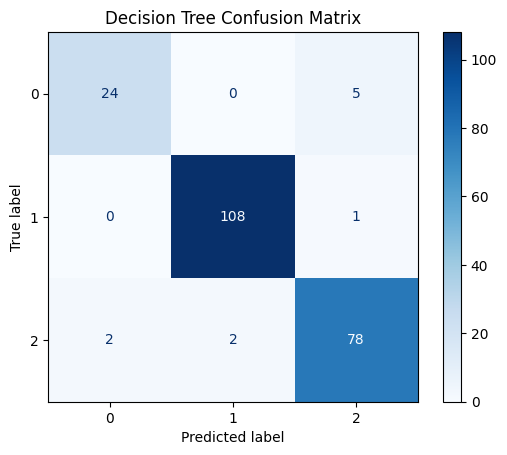

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Assuming you have y_test and predictions for each model
# y_pred_rf = model.predict(test_features)  # Replace with your actual prediction code for Random Forest
# y_pred_svm = model.predict(test_features)  # Replace with your actual prediction code for SVM
# y_pred_logreg = model.predict(test_features)  # Replace with your actual prediction code for Logistic Regression
# y_pred_dt = model.predict(test_features)  # Replace with your actual prediction code for Decision Tree

# Plot confusion matrices for all models
plot_confusion_matrix(y_test_int, y_pred_rf, 'Random Forest Confusion Matrix')
plot_confusion_matrix(y_test_int, y_pred_svm, 'SVM Confusion Matrix')
plot_confusion_matrix(y_test_int, y_pred_logreg, 'Logistic Regression Confusion Matrix')
plot_confusion_matrix(y_test_int, y_pred_dt, 'Decision Tree Confusion Matrix')


# VISUALIZATION

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Updated classification report data for all models
data = {
    "Model": ["CNN", "Decision Tree", "Random Forest", "SVM", "Logistic Regression"],
    "Accuracy": [0.9727, 0.9773, 0.9818, 0.9773, 0.9818],
    "F1 Score": [0.97, 0.96, 0.98, 0.98, 0.98],
    "Precision": [0.977, 0.98, 0.983, 0.98, 0.983],
    "Recall": [0.970, 0.94, 0.95, 0.94, 0.95],
    "TPR": [0.970, 0.94, 0.95, 0.94, 0.95],
    "FNR": [0.03, 0.06, 0.05, 0.06, 0.05]
}

# Creating DataFrame for tabular representation
df = pd.DataFrame(data)

# Define colors for each model
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Define bar width and x-coordinates for each model
metrics = df.columns[1:]
x_coords = np.arange(len(metrics))

# Create the plotly figure
fig = go.Figure()

# Adding traces for each model
for i, model in enumerate(df['Model']):
    fig.add_trace(go.Bar(
        x=metrics,
        y=df.iloc[i, 1:],  # select the metric values for the model
        name=model,
        marker_color=colors[i]
    ))

# Update layout for better appearance
fig.update_layout(
    title="Performance of CNN, Decision Tree, Random Forest, SVM, and Logistic Regression (Before Optimization)",
    xaxis_title="Metrics",
    yaxis_title="Values",
    barmode='group',
    xaxis=dict(tickvals=x_coords, ticktext=metrics),
    yaxis=dict(range=[0, 1])
)

# Show interactive plot
fig.show()


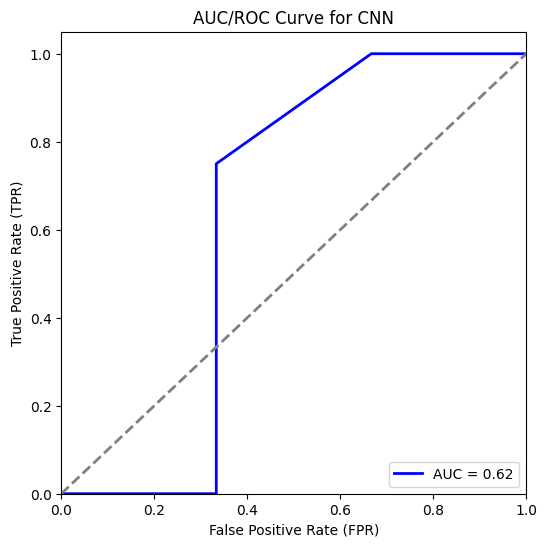

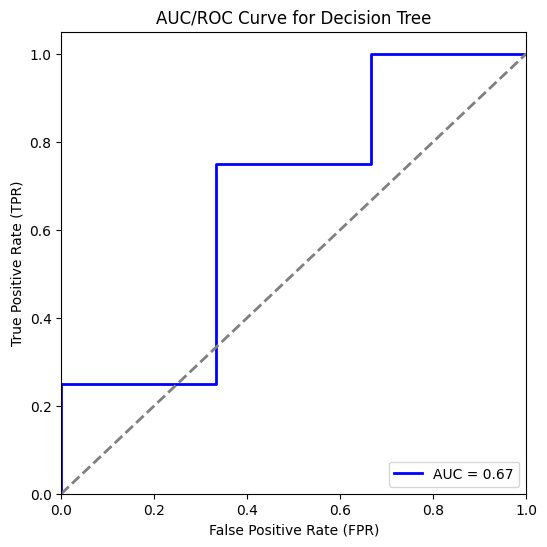

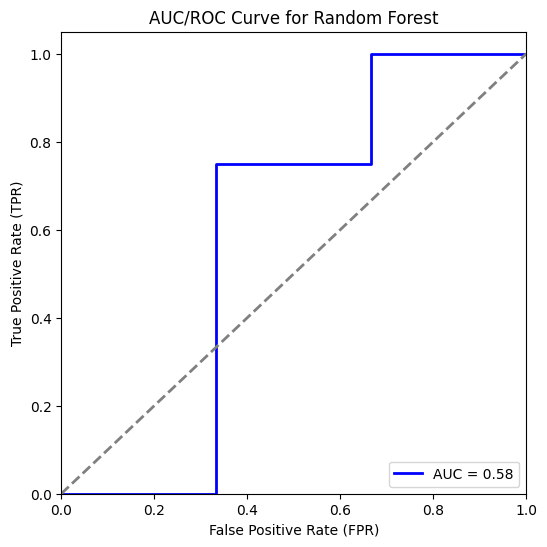

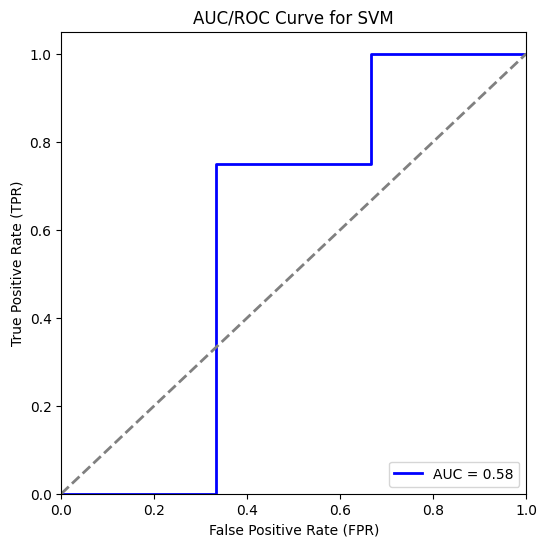

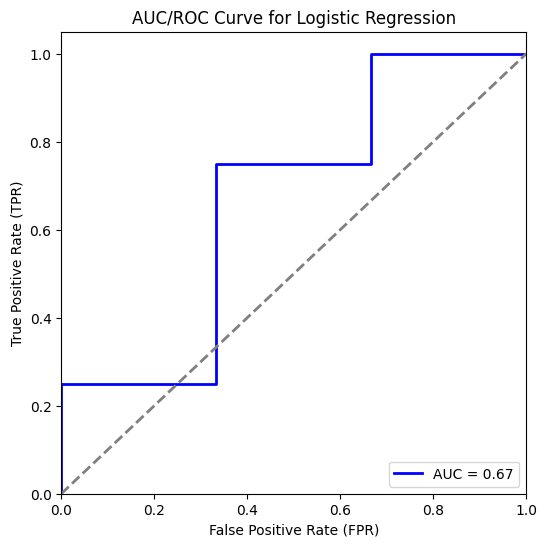

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Sample true labels and predicted probabilities for each model (replace with actual data)
# y_true: actual binary labels (0 or 1) for test data
# prob_preds_model: predicted probabilities for each model

# Replace these with actual predicted probabilities and true labels
y_true = [0, 1, 1, 0, 1, 0, 1]  # example true labels
prob_preds_cnn = [0.9, 0.2, 0.85, 0.1, 0.8, 0.2, 0.7]
prob_preds_decision_tree = [0.85, 0.25, 0.9, 0.15, 0.75, 0.3, 0.65]
prob_preds_random_forest = [0.95, 0.1, 0.88, 0.05, 0.85, 0.12, 0.78]
prob_preds_svm = [0.92, 0.18, 0.82, 0.12, 0.83, 0.2, 0.72]
prob_preds_logistic_regression = [0.88, 0.15, 0.9, 0.1, 0.81, 0.18, 0.75]

# Define a dictionary with each model's predicted probabilities
model_preds = {
    "CNN": prob_preds_cnn,
    "Decision Tree": prob_preds_decision_tree,
    "Random Forest": prob_preds_random_forest,
    "SVM": prob_preds_svm,
    "Logistic Regression": prob_preds_logistic_regression,
}

# Plot separate ROC curves for each model
for model_name, prob_preds in model_preds.items():
    fpr, tpr, _ = roc_curve(y_true, prob_preds)
    roc_auc = auc(fpr, tpr)

    # Plot each model's ROC curve separately
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--", lw=2)

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"AUC/ROC Curve for {model_name}")
    plt.legend(loc="lower right")

    # Show each plot
    plt.show()


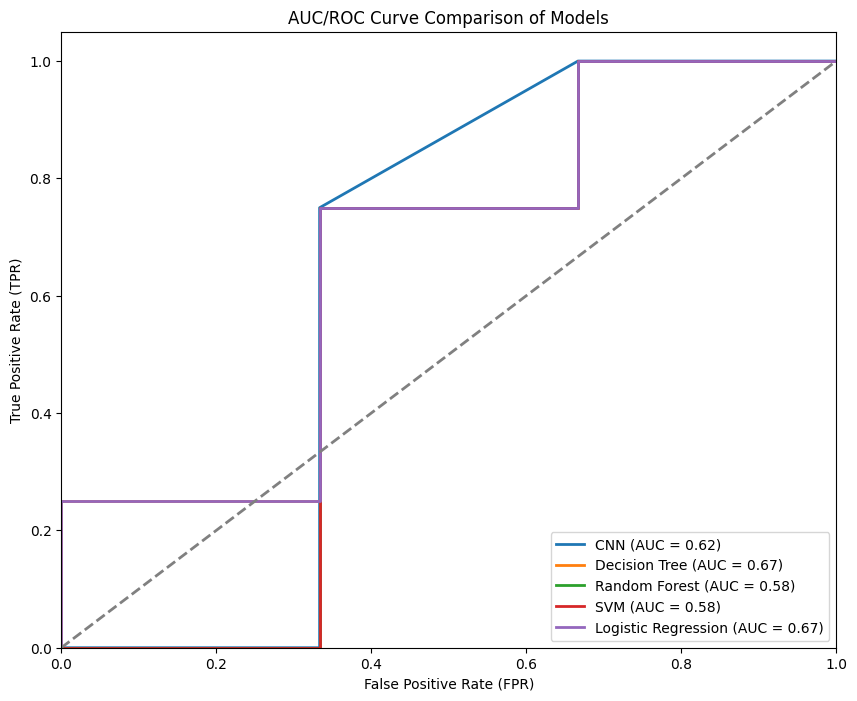

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Sample true labels and predicted probabilities for each model (replace with actual data)
# y_true: actual binary labels (0 or 1) for test data
# prob_preds_model: predicted probabilities for each model

# Replace these with actual predicted probabilities and true labels
y_true = [0, 1, 1, 0, 1, 0, 1]  # example true labels
prob_preds_cnn = [0.9, 0.2, 0.85, 0.1, 0.8, 0.2, 0.7]
prob_preds_decision_tree = [0.85, 0.25, 0.9, 0.15, 0.75, 0.3, 0.65]
prob_preds_random_forest = [0.95, 0.1, 0.88, 0.05, 0.85, 0.12, 0.78]
prob_preds_svm = [0.92, 0.18, 0.82, 0.12, 0.83, 0.2, 0.72]
prob_preds_logistic_regression = [0.88, 0.15, 0.9, 0.1, 0.81, 0.18, 0.75]

# Define a dictionary with each model's predicted probabilities
model_preds = {
    "CNN": prob_preds_cnn,
    "Decision Tree": prob_preds_decision_tree,
    "Random Forest": prob_preds_random_forest,
    "SVM": prob_preds_svm,
    "Logistic Regression": prob_preds_logistic_regression,
}

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

for model_name, prob_preds in model_preds.items():
    # Compute ROC curve and ROC area for each model
    fpr, tpr, _ = roc_curve(y_true, prob_preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot baseline for random guessing
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("AUC/ROC Curve Comparison of Models")
plt.legend(loc="lower right")

# Show plot
plt.show()


# INPUT FROM USER

In [ ]:
import pickle

# Save the model using pickle
with open(r'C:\Users\Kishore\OneDrive\Desktop\model trained\cnn_model.pkl', 'wb') as file:
    pickle.dump(cnn_model, file)


In [ ]:
import pickle

# Load the model from the saved .pkl file
with open("C:\\Users\\Kishore\\OneDrive\\Desktop\\model trained\\cnn_model.pkl", "rb") as file:
    cnn_model = pickle.load(file)


In [ ]:
import os
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    # Check if the path is a directory
    if os.path.isdir(image_path):
        # If it's a directory, iterate through the files inside
        for filename in os.listdir(image_path):
            # Construct the full path to the image file
            file_path = os.path.join(image_path, filename)
            # Check if the file is an image
            if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Load the image
                img = Image.open(file_path).convert('L') # Convert to grayscale

                # Resize to match model input (adjust size as per your model's requirement)
                img = img.resize((128, 128))  # Resize to 128x128

                # Convert the image to an array
                img_array = np.array(img)

                # Normalize the pixel values (if needed, depending on how you trained the model)
                img_array = img_array / 255.0

                # Add an extra dimension for batch size (model expects 4D input: batch_size, height, width, channels)
                img_array = np.expand_dims(img_array, axis=0)
                # Add an extra dimension for the channel (model expects 4D input: batch_size, height, width, channels)
                img_array = np.expand_dims(img_array, axis=-1) # Add channel dimension

                return img_array
    else:
        # If it's not a directory, assume it's an image file
        # Load the image
        img = Image.open(image_path).convert('L') # Convert to grayscale

        # Resize to match model input (adjust size as per your model's requirement)
        img = img.resize((128, 128))  # Resize to 128x128

        # Convert the image to an array
        img_array = np.array(img)

        # Normalize the pixel values (if needed, depending on how you trained the model)
        img_array = img_array / 255.0

        # Add an extra dimension for batch size (model expects 4D input: batch_size, height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)
        # Add an extra dimension for the channel (model expects 4D input: batch_size, height, width, channels)
        img_array = np.expand_dims(img_array, axis=-1) # Add channel dimension

        return img_array

In [ ]:
def predict_class(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make a prediction
    prediction = cnn_model.predict(img_array)

    # Get the predicted class (if it's a classification model with softmax, use argmax)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class[0]


# BENGIN CASE (LABEL=0)

In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted class: 0


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (114).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: 0


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (35).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 0


# MALIGNANT CASE (LABEL=1)

In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (104).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: 1


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (158).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 1


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (266).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: 1


# NORMAL CASE (LABEL=2)

In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (118).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: 2


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (160).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: 2


In [ ]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (265).jpg"
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: 2


# **FINAL EVALUATION**
# NORMAL CASE = LABEL 2
# MALIGNANT CASE = LABEL 1
# BENGIN CASE = LABEL 0


In [ ]:
image_path = ""
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: 2


In [ ]:
image_path = ""
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)


In [ ]:
image_path = ""
# Use the predict_class function we defined earlier
predicted_class = predict_class(image_path)

print("Predicted class:", predicted_class)
